In [120]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from scipy.stats import mstats
from statsmodels.regression.rolling import RollingOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest

In [76]:
data = pd.read_csv('data.csv', sep=';')
data['date'] = pd.to_datetime(data['date'])  # First, ensure that "date" is in datetime format
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

In [77]:


# 1. Remove stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data 
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))



In [78]:
# 1. Quintiles
data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
data['vw_Q'] = data['mcap']/data.groupby(['date','beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
vw_ret_sr = vw_ret_mean/vw_ret_std

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()
ew_ret_sr = ew_ret_mean/ew_ret_std

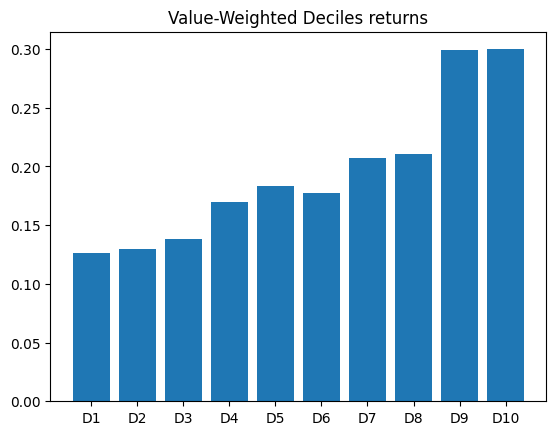

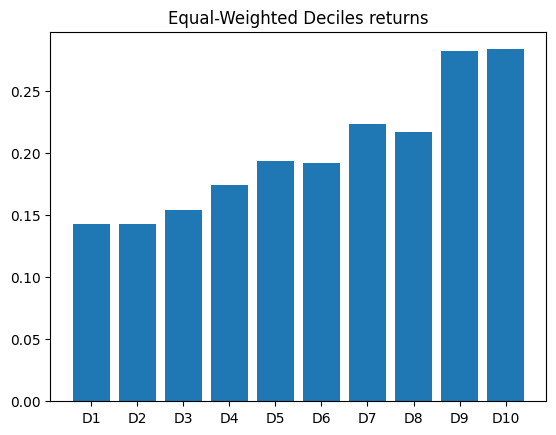

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles returns'),
 None)

In [79]:
# 5. Plot Histogram
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_ret_mean*12),plt.title('Value-Weighted Deciles returns'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_ret_mean*12),plt.title('Equal-Weighted Deciles returns'), plt.show()

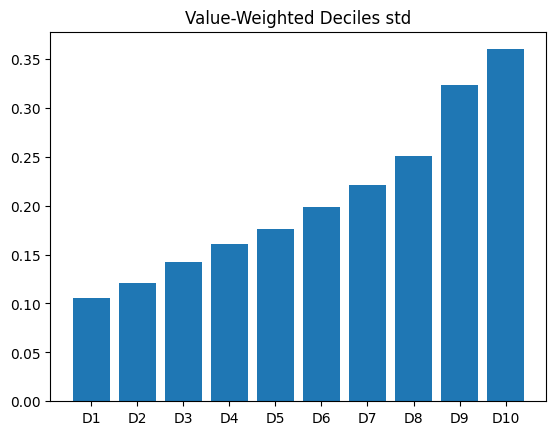

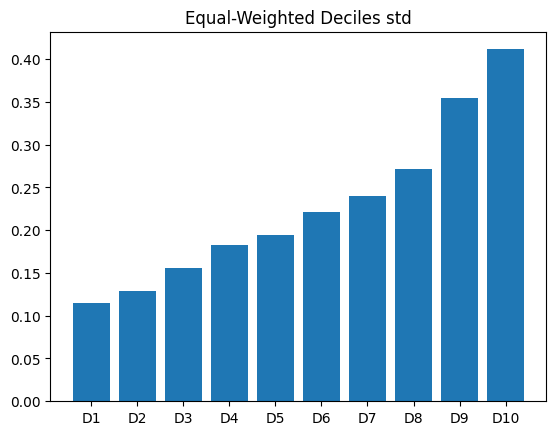

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles std'),
 None)

In [80]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_ret_std*np.sqrt(12)),plt.title('Value-Weighted Deciles std'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_ret_std*np.sqrt(12)),plt.title('Equal-Weighted Deciles std'), plt.show()

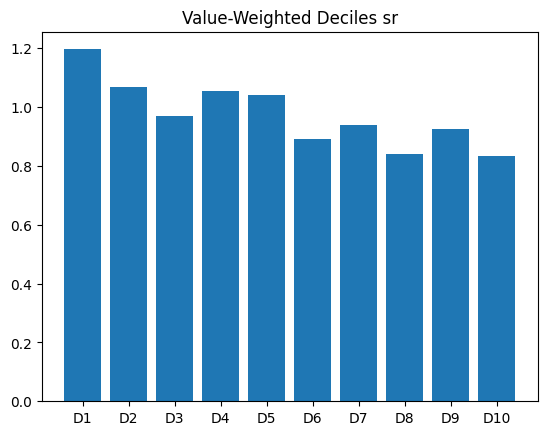

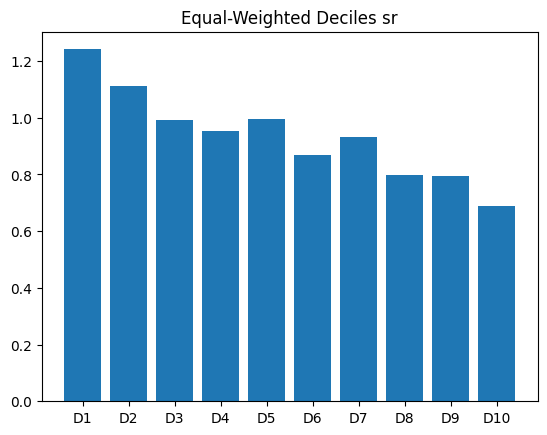

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles sr'),
 None)

In [82]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_ret_mean/vw_ret_std*np.sqrt(12)),plt.title('Value-Weighted Deciles sr'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_ret_mean/ew_ret_std*np.sqrt(12)),plt.title('Equal-Weighted Deciles sr'), plt.show()

In [37]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()

# Levered and unlevered returns
BAB['BAB1'] = BAB['R_L'] - BAB['R_H']
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']

In [41]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params.iloc[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params.iloc[1]

print('Annualized Alpha of BAB factor with its t-value: ', Alpha_bab, OLS_Reg.tvalues.iloc[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
#print('Beta BAB: ',beta_bab)
#print('Market Risk Premium: ',market_rp)
#print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.07329785300230429 2.5025236213956714
Sharpe Ratio of BAB factor:  0.5434514448331147
Idiosyncatic volatility:  0.13479773771783268


# 4 Momentum Strategy

In [88]:
# Import data
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])  # First, ensure that "date" is in datetime format
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

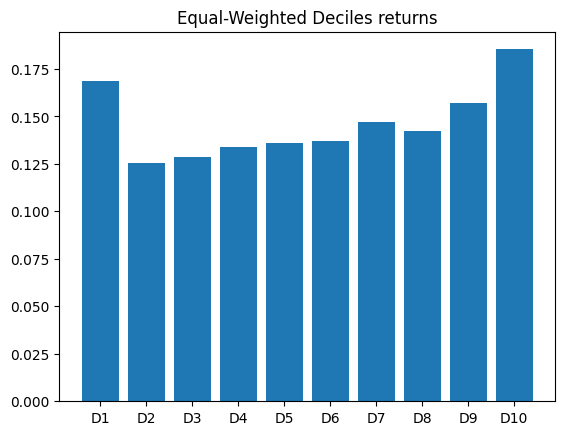

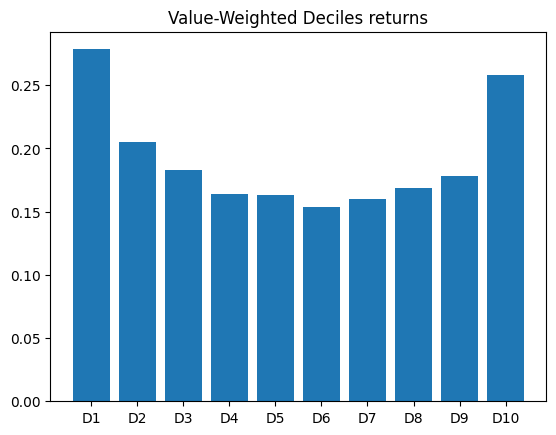

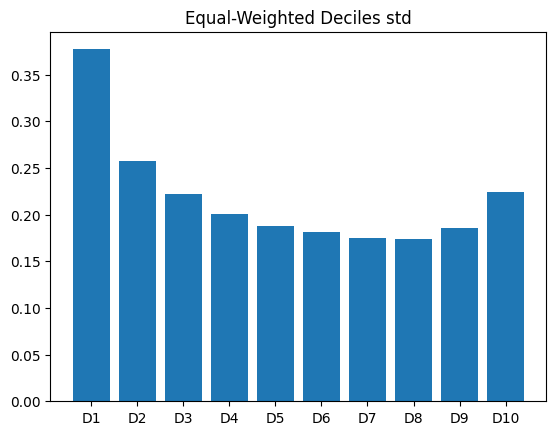

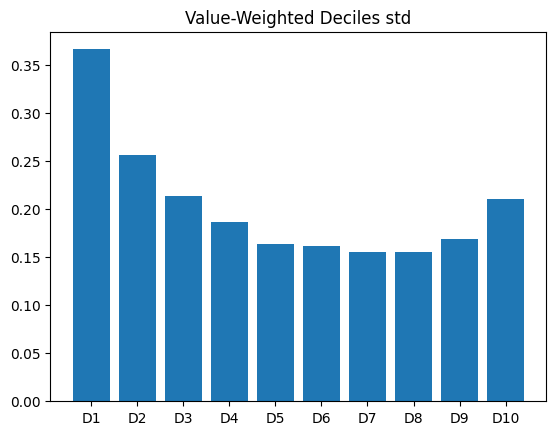

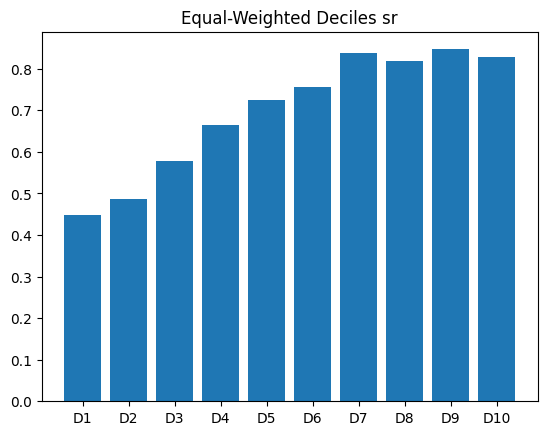

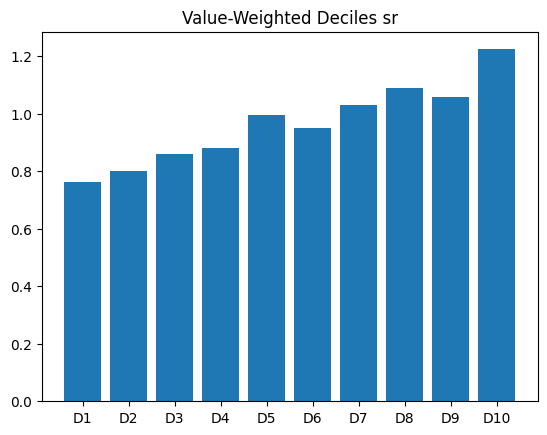

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles sr'),
 None)

In [99]:
data=data.sort_values(['permno','date']).reset_index(drop=True)
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum(),include_groups=False).values
q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))

#value weighted portfolios
data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')
data['vw_Rn'] = data['vw_Q']*data['Rn']
vw_returns = data.groupby(['date','Momentum'])['vw_Rn'].sum().reset_index()
vw_returns_mean = vw_returns.groupby('Momentum')['vw_Rn'].mean()
vw_returns_std = vw_returns.groupby('Momentum')['vw_Rn'].std()
vw_returns_sr = vw_returns_mean/vw_returns_std

#equal weighted portfolios
ew_returns = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_returns_mean = ew_returns.groupby('Momentum')['Rn'].mean()
ew_returns_std = ew_returns.groupby('Momentum')['Rn'].std()
ew_returns_sr = ew_returns_mean/ew_returns_std

plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_returns_mean*12),plt.title('Equal-Weighted Deciles returns'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_returns_mean*12),plt.title('Value-Weighted Deciles returns'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_returns_std*np.sqrt(12)),plt.title('Equal-Weighted Deciles std'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_returns_std*np.sqrt(12)),plt.title('Value-Weighted Deciles std'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_returns_sr*12/np.sqrt(12)),plt.title('Equal-Weighted Deciles sr'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_returns_sr*12/np.sqrt(12)),plt.title('Value-Weighted Deciles sr'),plt.show()

In [116]:
data['w_L'] = (data['Momentum']>=q-3)*data['mcap']
data['w_S'] = (data['Momentum']>=2)*data['mcap']
data['w_L'] = data['w_L']/data.groupby(['date'])['w_L'].transform('sum')
data['w_S'] = data['w_S']/data.groupby(['date'])['w_S'].transform('sum')
data['w_Mom'] = data['w_L'] - data['w_S']
Momentum = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_Mom']),include_groups=False).reset_index()
Momentum['date'] =  Momentum['date'] + pd.DateOffset(months=1)
Momentum.columns = ['date','Mom_ret']

data['vw_w_L'] = (data['Momentum']>=q-3)*(data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum'))
data['vw_w_S'] = (data['Momentum']>=2)*(data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum'))
data['vw_w_L'] = data['vw_w_L']/data.groupby(['date'])['vw_w_L'].transform('sum')
data['vw_w_S'] = data['vw_w_S']/data.groupby(['date'])['vw_w_S'].transform('sum')
data['vw_w_Mom'] = data['vw_w_L'] - data['vw_w_S']
Momentum_vw = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['vw_w_Mom']),include_groups=False).reset_index()
Momentum_vw['date'] =  Momentum_vw['date'] + pd.DateOffset(months=1)
Momentum_vw.columns = ['date','Mom_ret_vw']


In [113]:
def get_info(data, weights_col_name):
    returns = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x[weights_col_name]),include_groups=False).reset_index()
    returns['date'] =  returns['date'] + pd.DateOffset(months=1)
    returns.columns = ['date','ret']
    print('Annualized return: ', returns['ret'].mean()*12)
    print('Annualized std:    ', returns['ret'].std()*np.sqrt(12))
    print('SR:                ', returns['ret'].mean()*12/returns['ret'].std()/np.sqrt(12))



In [114]:
for col in ['w_L','w_S', 'vw_w_L','vw_w_S']:
    print('For column ', col)
    get_info(data, col)
    

For column  w_L
Annualized return:  0.18660630565609884
Annualized std:     0.1616102119617041
SR:                 1.1546690236401518
For column  w_S
Annualized return:  0.1632652396581109
Annualized std:     0.14694534552594668
SR:                 1.1110609803512461
For column  vw_w_L
Annualized return:  0.19866404785039166
Annualized std:     0.16690260206711402
SR:                 1.190299284672062
For column  vw_w_S
Annualized return:  0.17590083620043379
Annualized std:     0.1570109102165212
SR:                 1.1203096393611311


Information on the momentum strategy

For column  w_Mom
Annualized return:  0.02334106599798796
Annualized std:     0.06143728030947723
SR:                 0.3799169800553069
For column  vw_w_Mom
Annualized return:  0.02276321164995789
Annualized std:     0.07089745437825115
SR:                 0.3210723410252773


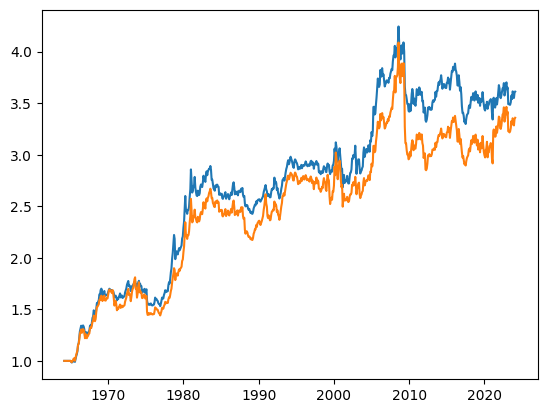

In [119]:
for col in ['w_Mom','vw_w_Mom']:
    print('For column ', col)
    get_info(data, col)
plt.plot(Momentum['date'],(Momentum['Mom_ret']+1).cumprod())
plt.plot(Momentum_vw['date'],(Momentum_vw['Mom_ret_vw']+1).cumprod())

In [118]:
from statsmodels.stats.weightstats import ztest
z_stat_equal, p_value_equal = ztest(Momentum['Mom_ret'], value=0, alternative='two-sided')
z_stat_weighted, p_value_weighted = ztest(Momentum_vw['Mom_ret_vw'], value=0, alternative='two-sided')

print('p value for Mom porfolio with equal weights: '+str(p_value_equal))
print('p value for Mom portfolio with value-weighted weights: '+str(p_value_weighted))

p value for Mom porfolio with equal weights: 0.003273870322414203
p value for Mom portfolio with value-weighted weights: 0.012944667559922789


Seems like the result we get is rather insignificant, at least in the case of unweighted weights

# 5 Idiosyncratic Volatility Strategy

In [123]:
from tqdm import tqdm
def rolling_ols_resid_std(data, window, min_periods):
    resid_std = pd.Series(index=data.index, dtype=float)

    for start in tqdm(range(len(data))):
        end = start + window
        if end > len(data):
            break
        # Slice the window of data
        df_window = data.iloc[start:end]
        if len(df_window) >= min_periods:
            # Prepare data for OLS: dependent and independent variables
            X = add_constant(df_window['Rm_e'])
            y = df_window['Rn_e']
            # Perform OLS regression
            model = OLS(y, X).fit()
            # Calculate residuals
            residuals = model.resid
            # Calculate the standard deviation of the residuals
            resid_std.iloc[end - 1] = residuals.std()

    return resid_std

In [124]:
# Generate the data once, then just load it
data = pd.read_csv('data.csv', sep=';')
data['date'] = pd.to_datetime(data['date'])  # First, ensure that "date" is in datetime format
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

MIN_OBS = 36
WINDOW_SIZE = 60
data = data.groupby('permno').filter(lambda x: len(x) >= MIN_OBS)
#data['resid_vol'] = rolling_ols_resid_std(data, window=WINDOW_SIZE, min_periods=MIN_OBS)
data['resid_vol'] = rolling_ols_resid_std(data, window=WINDOW_SIZE, min_periods=MIN_OBS)
data.to_csv('5A_data.csv', index=False)

100%|█████████▉| 1383462/1383521 [13:04<00:00, 1763.89it/s]


In [ ]:
#loading, dropping nas and winsorising
data = pd.read_csv('5A_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.dropna(subset=['resid_vol'], inplace=True)
#windsoriszing idiosyncratic volatility
lower_bound = data['resid_vol'].quantile(0.05)
upper_bound = data['resid_vol'].quantile(0.95)
data['resid_vol'] = data['resid_vol'].clip(lower_bound, upper_bound)

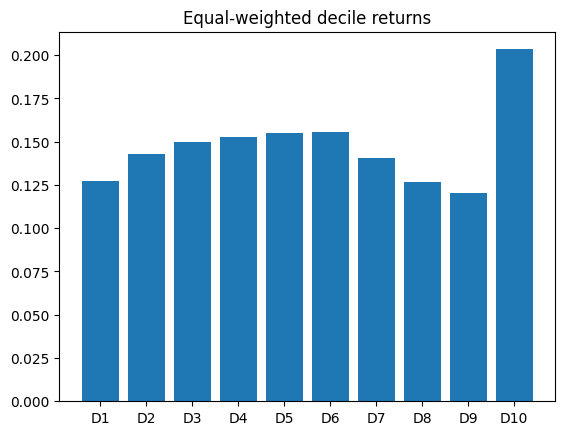

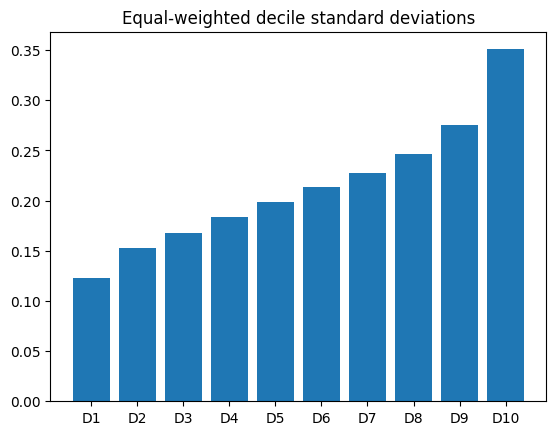

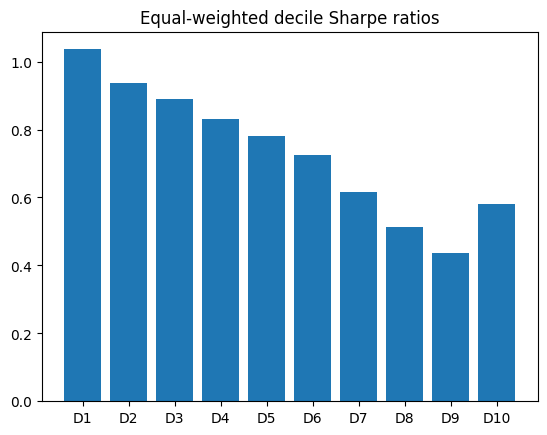

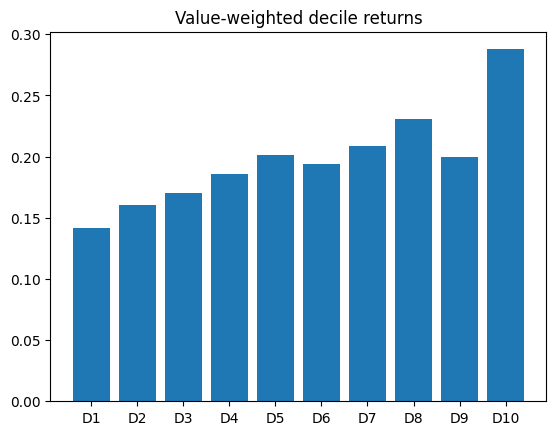

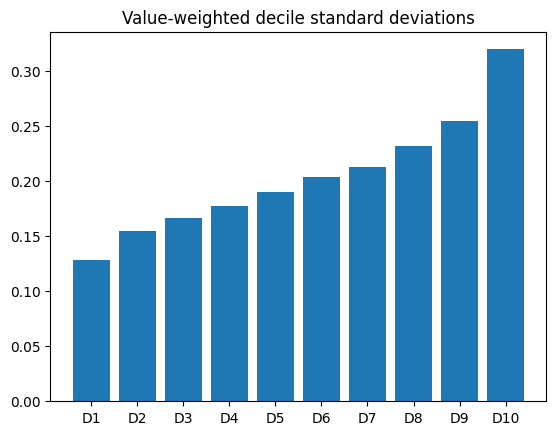

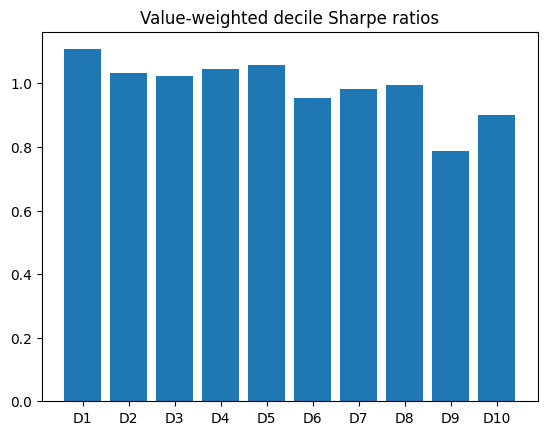

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-weighted decile Sharpe ratios'),
 None)

In [127]:
#5.b
#equal-weighted


#value-weighted 
data['decile'] = data.groupby('date')['resid_vol'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
data['vw'] = data['mcap'] / data.groupby(['date', 'decile'])['mcap'].transform('sum')
data['vw_ret'] = data['vw'] * data['Rn']
eq_ret = data.groupby(['date', 'decile'])['Rn'].mean().reset_index() 
plt.bar(['D'+str(i) for i in range(1, 11)], eq_ret.groupby('decile')['Rn'].mean()*12), plt.title('Equal-weighted decile returns'), plt.show()
plt.bar(['D'+str(i) for i in range(1, 11)], eq_ret.groupby('decile')['Rn'].std()*np.sqrt(12)),plt.title('Equal-weighted decile standard deviations'), plt.show()
plt.bar(['D'+str(i) for i in range(1, 11)], eq_ret.groupby('decile')['Rn'].mean()/eq_ret.groupby('decile')['Rn'].std()*np.sqrt(12)),plt.title('Equal-weighted decile Sharpe ratios'),plt.show()
vw_ret = data.groupby(['date', 'decile'])['vw_ret'].sum().reset_index()
plt.bar(['D'+str(i) for i in range(1, 11)], vw_ret.groupby('decile')['vw_ret'].mean()*12), plt.title('Value-weighted decile returns'), plt.show()
plt.bar(['D'+str(i) for i in range(1, 11)], vw_ret.groupby('decile')['vw_ret'].std()*np.sqrt(12)),plt.title('Value-weighted decile standard deviations'), plt.show()
plt.bar(['D'+str(i) for i in range(1, 11)], vw_ret.groupby('decile')['vw_ret'].mean()/vw_ret.groupby('decile')['vw_ret'].std()*np.sqrt(12)),plt.title('Value-weighted decile Sharpe ratios'),plt.show()